# ESG Document Classifier with Transformers

This is the current iteration of this model
- Read the PDF (full text)
- Filter out short text. Keep only the long one. To eliminate unneccessary labels
- Feed the content into DeBERTa and run fine-tuning.


In [ ]:
%%bash
pip install -U pypdfium2 wordcloud
pip install -U git+https://github.com/huggingface/transformers.git
pip install -U git+https://github.com/huggingface/accelerate.git
pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 11.3 MB/s eta 0:00:00
  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-jtq6onvv
  Resolved https://github.com/huggingface/transformers.git to commit 52574026b6740a3882d6dd1cbf1e1663d4cea27b
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.0 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.33.0.dev0-py3-none-any.whl size=7604297 sha256=8908c9d9159a6246172097d2b0870b2741ec2c5e4d705e56

  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-jtq6onvv
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate.git /tmp/pip-req-build-i5friwgz


**Please restart kernel** after running the installation blocks

In [ ]:
from wordcloud import WordCloud
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pypdfium2 as pdfium
import re

%matplotlib inline

# Helper Functions

In [ ]:
def get_pdf(path):
    return pdfium.PdfDocument(path)

def get_content(page):
    textpage = page.get_textpage()
    return textpage.get_text_range()

def render(page):
    bitmap = page.render(
        scale = 1,    # 72dpi resolution
        rotation = 0, # no additional rotation
    )
    return bitmap.to_pil()

def extract_content_from_id(file_id: str) -> str :
    # extract filename and page
    items = file_id.split('.')
    filename = '.'.join(items[:2])
    page_num = int(items[-1])-1

    # load pdf, select page, and extract its content
    filepath = os.path.join(report_path, filename)
    pdf = get_pdf(filepath)
    page = pdf[page_num]
    content = get_content(page)

    content = " ".join(content.lower().split())
    return content

def keep_only_allowed_chars(text):
    pattern = r'[^A-Za-z0-9.,\-_ ()\'"]'
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text.strip()

def clean_text(text):
    return ". ".join([keep_only_allowed_chars(line) for line in text.lower().splitlines() if len(line.split()) >= 5])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read a page of a PDF

In [ ]:
filepath = '/content/drive/MyDrive/LLM_1/ESGreps/pdf_reps/report_279.pdf'

pdf = get_pdf(filepath)
page = pdf[28]
content = get_content(page)

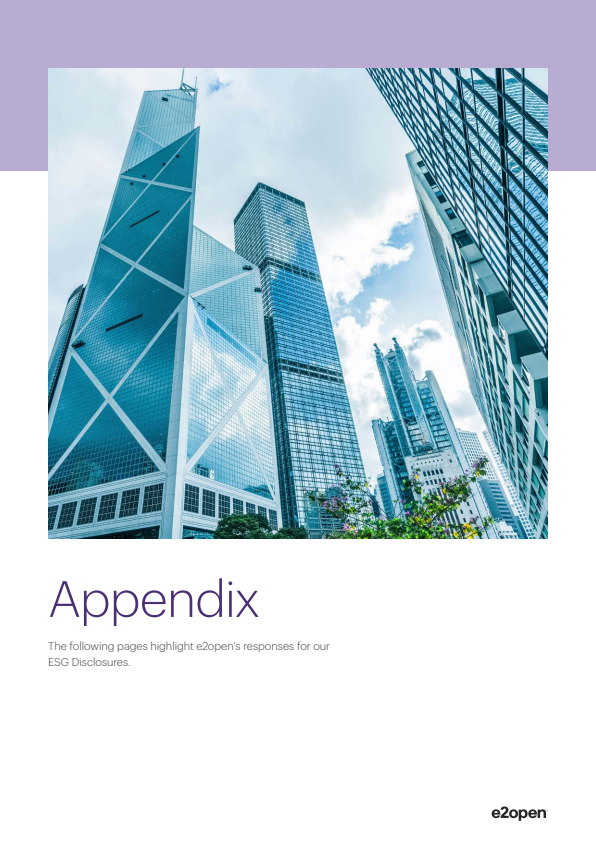

In [ ]:
render(page)

In [ ]:
print(content)

Appendix
The following pages highlight e2open’s responses for our
ESG Disclosures.


# Load Data

In [ ]:
basepath = "/content/drive/MyDrive/LLM_1/ESG/data"
report_path = os.path.join(basepath, "ESG_reports")
label_path = os.path.join(basepath, "labels.csv")

In [ ]:
df = pd.read_csv(label_path)

df.head()

,id,class
0,report_519.pdf.53,governance
1,report_1537.pdf.24,social
2,report_567.pdf.33,governance
3,report_1830.pdf.220,other
4,report_1253.pdf.46,governance


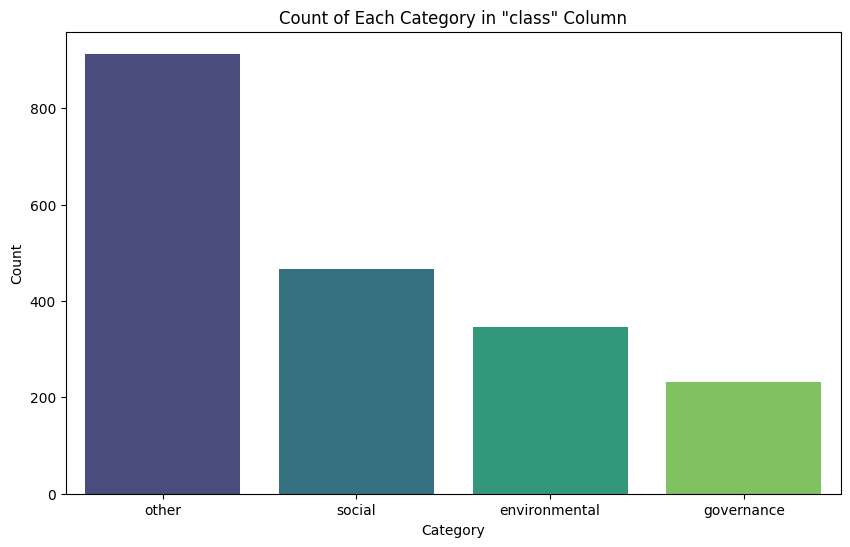

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each category in the "class" column
category_counts = df['class'].value_counts()

# Plot these counts using a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")
plt.title('Count of Each Category in "class" Column')
plt.ylabel('Count')
plt.xlabel('Category')
plt.show()

In [ ]:
contents = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    file_id = row['id']
    content = extract_content_from_id(file_id)
    content = clean_text(content)
    contents.append(content)

df['content'] = contents

  0%|          | 0/1956 [00:00<?, ?it/s]

In [ ]:
df.head()

,id,class,content
0,report_519.pdf.53,governance,"2021 esg impact report data privacy, security,..."
1,report_1537.pdf.24,social,2021 sustainability report table of contents 2...
2,report_567.pdf.33,governance,sustainability governance clean harbors commit...
3,report_1830.pdf.220,other,220 report of the rviseur dentreprises agr ev...
4,report_1253.pdf.46,governance,46 pfizer 2021 esg report governance governanc...


In [ ]:
from sklearn import preprocessing

# Encode the label classes
label_encoder = preprocessing.LabelEncoder()
df['label'] = label_encoder.fit_transform(df['class'])
print(label_encoder.classes_)

['environmental' 'governance' 'other' 'social']


In [ ]:
df.head()

,id,class,content,label
0,report_519.pdf.53,governance,"2021 esg impact report data privacy, security,...",1
1,report_1537.pdf.24,social,2021 sustainability report table of contents 2...,3
2,report_567.pdf.33,governance,sustainability governance clean harbors commit...,1
3,report_1830.pdf.220,other,220 report of the rviseur dentreprises agr ev...,2
4,report_1253.pdf.46,governance,46 pfizer 2021 esg report governance governanc...,1


In [ ]:
from sklearn.model_selection import train_test_split

# Split Train/Test set with 80:20
X_train, X_test, y_train, y_test = train_test_split(df['content'], df['label'], test_size=.2, random_state=168)

# Classification with Transformers

## PreProcessing Dataset

In [ ]:
 #using the Hugging Face Transformers library to tokenize text data using the
 #"microsoft/deberta-base" pretrained model

from transformers import AutoTokenizer #import the AutoTokenizer class from the Hugging Face Transformers library.

tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-base")#load a pretrained tokenizer

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

#the loaded tokenizer is applied to the text examples using the tokenizer() method.
#The padding parameter is set to "max_length", which ensures that all tokenized sequences
#have the same length by adding padding tokens.
#The truncation parameter is set to True, which truncates sequences that exceed the maximum token limit of the model.



Using the Hugging Face Transformers library to tokenize text data using the "microsoft/deberta-base" pretrained model offers several benefits:

Efficiency and Speed: The Hugging Face Transformers library provides highly optimized tokenization methods that can efficiently process large volumes of text data. This is crucial for tasks involving massive amounts of text, such as natural language processing (NLP) and machine learning.


Pretrained Tokenizer: The library comes with a variety of pretrained tokenizers that have been fine-tuned on diverse text data. The "microsoft/deberta-base" pretrained model's tokenizer is specifically designed to work with the DeBERTa architecture, ensuring accurate and consistent tokenization.

Consistency: Using a pretrained tokenizer ensures consistency in tokenization across different parts of your code and across different NLP tasks. This consistency is important for maintaining reproducibility and comparability of results.

Embedding Compatibility: The tokenization process is integral to generating input embeddings for NLP models. Using a pretrained tokenizer ensures that the input text is tokenized in a way that is compatible with the DeBERTa-based model's architecture and expectations.

Customization: While pretrained tokenizers are optimized for general use, they also offer customization options to accommodate specific requirements of your text data or task. This allows you to fine-tune tokenization parameters to suit your needs.

Integration with Transformers Models: The tokenization process aligns with the DeBERTa-based model's input requirements, making it easy to integrate the tokenized data with the model. This streamlines the preprocessing pipeline and simplifies the overall implementation.

Community Support: The Hugging Face Transformers library is widely used and has a large community of developers, researchers, and practitioners. This means that you can find support, resources, and examples to guide you through tokenization and other NLP-related tasks.



In [ ]:
#load_dataset, Dataset, and DatasetDict classes from the Hugging Face Datasets library.
from datasets import load_dataset, Dataset, DatasetDict

#Two datasets, dataset_train and dataset_test, are created from the training and testing data
#Each dataset is constructed using a dictionary containing two keys: "text" and "label".
#The "text" key holds a list of text samples, and the "label" key holds a list of corresponding labels.
dataset_train = Dataset.from_dict({"text": X_train.tolist(), "label": y_train.tolist()})
dataset_test = Dataset.from_dict({"text": X_test.tolist(), "label": y_test.tolist()})
dataset = DatasetDict({
    "train": dataset_train,
    "test": dataset_test
})

In [ ]:
dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1564 [00:00<?, ? examples/s]

Map:   0%|          | 0/392 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1564
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 392
    })
})

## Setup Trainer

In [ ]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
#using the Hugging Face Transformers library to load a pretrained model for
#sequence classification, specifically the "microsoft/deberta-base" model,
#and configure it for a specific number of labels

from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-base", num_labels=4)

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments, Trainer
#Imports the TrainingArguments class and the Trainer class from the Hugging Face Transformers library.
#Trainer is a high-level training and evaluation loop class that simplifies the process of training models.
#It takes care of the complete training pipeline, including data loading, optimization, backpropagation, and evaluation.
#It abstracts away many low-level details, allowing users to focus on defining the model, the dataset, and the training configuration.
#The Trainer class integrates with the provided TrainingArguments to handle training according to the specified settings

training_args = TrainingArguments(   #configure the training process
    output_dir="test_trainer",
    evaluation_strategy="epoch",
    report_to='none',
    load_best_model_at_end=True,
    save_strategy="epoch",
    num_train_epochs=2,
)

In [ ]:

#By creating the Trainer instance with these configurations, you're setting up the entire training
#and evaluation loop. The Trainer class will handle loading data, optimizing the model
trainer = Trainer(
    model=model, #pre-trained model
    args=training_args,#instance of the TrainingArguments class
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.308023,0.900510
2,No log,0.220857,0.951531


TrainOutput(global_step=392, training_loss=0.4600390609429807, metrics={'train_runtime': 199.7779, 'train_samples_per_second': 15.657, 'train_steps_per_second': 1.962, 'total_flos': 959052069371904.0, 'train_loss': 0.4600390609429807, 'epoch': 2.0})

I previously tried to train for three epochs. The validation loss remains the same, but that could mean it overfits a little. So I re-ran and select two epochs instead.

In [ ]:
# Evaluate to test if we load the best model (not just the latest)
trainer.evaluate(dataset['test'])

{'eval_loss': 0.22085677087306976,
 'eval_accuracy': 0.951530612244898,
 'eval_runtime': 7.1586,
 'eval_samples_per_second': 54.759,
 'eval_steps_per_second': 6.845,
 'epoch': 2.0}

In [1]:

model2 = "distilbert-base-uncased"

In [ ]:
! pip install -U git+https://github.com/huggingface/transformers.git
! pip install -U git+https://github.com/huggingface/accelerate.git

%env TOKENIZERS_PARALLELISM=false
%env WANDB_DISABLED=true

from datasets import Dataset, load_metric
from transformers import (
    AutoTokenizer,
    AutoModel,
    AdamW,
    AutoConfig,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    AutoModelForSequenceClassification
)

import torch
import torch.nn as nn
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
import random

import numpy as np
import pandas as pd

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-chfsw0fr
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-chfsw0fr
  Resolved https://github.com/huggingface/transformers.git to commit 52574026b6740a3882d6dd1cbf1e1663d4cea27b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/huggingface/accelerate.git to /tmp/pip-req-build-g8v7yz5m
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate.git /tmp/pip-req-build-g8v7yz5m
  Resolved https://github.com/huggingface/accelerate.git to commit 0b5ac0253ec7fb795f2ddab47ce94b2881719b4c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
env: TOKENIZERS_PARALLELISM=false
env: WANDB_DISABLED=true


In [ ]:
#The AutoTokenizer class automatically selects the appropriate tokenizer for the given model name.
tokenizer = AutoTokenizer.from_pretrained(model)

#function called tokenize_fn that takes a dictionary examples as input
def tokenize_fn(examples):
    encoding = tokenizer(examples['text'], truncation=True)#this line uses the initialized tokenizer to tokenize
    #the text data from the examples dictionary. The examples['text'] contains the input text to be tokenized.
    encoding['labels'] = [one_hot_encode(x) for x in examples['labels']]
    #one_hot_encode being applied to each label value in examples['labels']
    return encoding

#training arguments for a machine learning model using the Hugging Face Transformers library.
batch_size = 16
metric_name = "f1"
num_train_epochs = 2
args = TrainingArguments(
    f"{model}-{batch_size}-{num_train_epochs}",#The output directory for saving checkpoints and other training-related artifacts.
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    #push_to_hub=True,
)

#This line creates an instance of a pre-trained sequence classification model.
model = AutoModelForSequenceClassification.from_pretrained(model,
                                                           problem_type="multi_label_classification",
                                                           num_labels=4)
#AutoModelForSequenceClassification.from_pretrained(model):
#This part loads a pre-trained model from the Hugging Face model repository.



Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch

# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/

#This line defines a function named multi_label_metrics that takes three arguments:
#predictions: The predicted scores or probabilities for each class for each sample in the batch.
#labels: The true binary labels for each sample in the batch.
#threshold: A threshold value to convert probabilities into binary predictions.
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions,
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds,
        labels=p.label_ids)
    return result

In [ ]:
pref_uniq = train['prefix'].unique()
random.shuffle(pref_uniq)

num_folds = 5
fold_scores = []
for i in range(0,100,100//num_folds):
    start = i/100
    end = start + 1/num_folds
    start = int(np.round(start * len(pref_uniq)))
    end = int(np.round(end*len(pref_uniq)))
    print(start,end,len(pref_uniq))
    ## selecting train and test set based on prefix of pdf files because of data leakage
    train_prefixes = np.array(list(pref_uniq[:start]) + list(pref_uniq[end:]))
    test_prefixes = pref_uniq[start:end]
#     train_prefixes_set = set(train_prefixes)
#     test_prefixes_set = set(test_prefixes)
#     common_prefixes = train_prefixes_set.intersection(test_prefixes_set)
#     print(len(common_prefixes),len(train_prefixes_set)+len(test_prefixes_set))


    X_train = train[train['prefix'].isin(train_prefixes)]
    X_test = train[train['prefix'].isin(test_prefixes)]
    xtrain = X_train['text'].values
    ytrain = X_train['class'].values
    xvalid = X_test['text'].values
    yvalid = X_test['class'].values
    train_dataset_raw = Dataset.from_dict({'text':xtrain, 'labels':ytrain})
    valid_dataset_raw = Dataset.from_dict({'text':xvalid, 'labels':yvalid})
    train_dataset = train_dataset_raw.map(tokenize_fn, batched=True)
    valid_dataset = valid_dataset_raw.map(tokenize_fn, batched=True)
    trainer = Trainer(
        model,
        args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )
    trainer.train()

    # Evaluate the model
    eval_result = trainer.evaluate()
    print(eval_result)
    # Record the evaluation metric for this fold
    fold_scores.append(eval_result)

NameError: ignored